# Validate embeddings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/11 10:28:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/11 10:28:33 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


### embeddings

In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Tue Feb 11 10:28:47 AM EST 2025


In [5]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/parquet_files/"

# Define the path to the train and test parquet files
train_path = f"{data_path}/train"

# Read the parquet files into a spark DataFrame
train_df = spark.read.parquet(train_path)

# Show the data
train_df.printSchema()
train_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)
 |-- organ: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- obs_id: long (nullable = true)
 |-- license: string (nullable = true)
 |-- partner: string (nullable = true)
 |-- author: string (nullable = true)
 |-- altitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- gbif_species_id: string (nullable = true)
 |-- species: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- family: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- references: string (nullable = true)
 |-- url: string (nullable = true)
 |-- learn_tag: string (nullable = true)
 |-- image_backup_url: string (nullable = true)



+--------------------+--------------------+--------------------+-----+----------+----------+--------------------+-------+----------------+--------+-----------------+------------------+---------------+--------------------+-------------+----------+--------+-----------+--------------------+--------------------+---------+--------------------+
|          image_name|                path|                data|organ|species_id|    obs_id|             license|partner|          author|altitude|         latitude|         longitude|gbif_species_id|             species|        genus|    family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|
+--------------------+--------------------+--------------------+-----+----------+----------+--------------------+-------+----------------+--------+-----------------+------------------+---------------+--------------------+-------------+----------+--------+-----------+--------------------+--------------------+---------

### subset embedding data

In [ ]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/"

# Define the path to the train and test parquet files
subset_train_path = f"{data_path}/embeddings/subset_top20_embeddings/data"

# Read the parquet files into a spark DataFrame
subset_df = spark.read.parquet(subset_train_path)

# Show the data
subset_df.printSchema()
subset_df.show(n=5)

root
 |-- image_name: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- cls_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)



+--------------------+----------+--------------------+---------+
|          image_name|species_id|       cls_embedding|sample_id|
+--------------------+----------+--------------------+---------+
|c8919e71290435c6c...|   1359162|[0.70828027, 0.58...|        0|
|40fff992c94ef20d9...|   1359162|[1.0190178, 0.406...|        0|
|26c2116634eeb31ca...|   1359162|[1.2954574, 0.567...|        0|
|284bcf6246a871ad0...|   1743246|[0.1810132, 0.335...|        0|
|4dd249bb75547f2db...|   1743246|[0.5320667, 0.108...|        0|
+--------------------+----------+--------------------+---------+
only showing top 5 rows



In [7]:
# Join with dino_df with train_df to get species names
joined_df = subset_df.join(train_df, "image_name", "inner").select(
    [
        subset_df["image_name"],
        train_df["species"],
        subset_df["species_id"],
        subset_df["cls_embedding"],
    ]
)
joined_df.show(n=5)

+--------------------+--------------------+----------+--------------------+
|          image_name|             species|species_id|       cls_embedding|
+--------------------+--------------------+----------+--------------------+
|010fb6728439fa33c...|    Arbutus unedo L.|   1358500|[0.56508285, 0.04...|
|012f6cf9d0c99da4a...|Castanea sativa M...|   1358610|[-0.2519482, -0.3...|
|0373d282562c38e3c...|Styphnolobium jap...|   1369068|[-0.28823447, 0.3...|
|0387667ac92605ae4...|   Lotus hirsutus L.|   1743246|[0.09958131, 0.55...|
|03c9960c30d1b8598...|Calicotome spinos...|   1359160|[0.39368477, -0.3...|
+--------------------+--------------------+----------+--------------------+
only showing top 5 rows



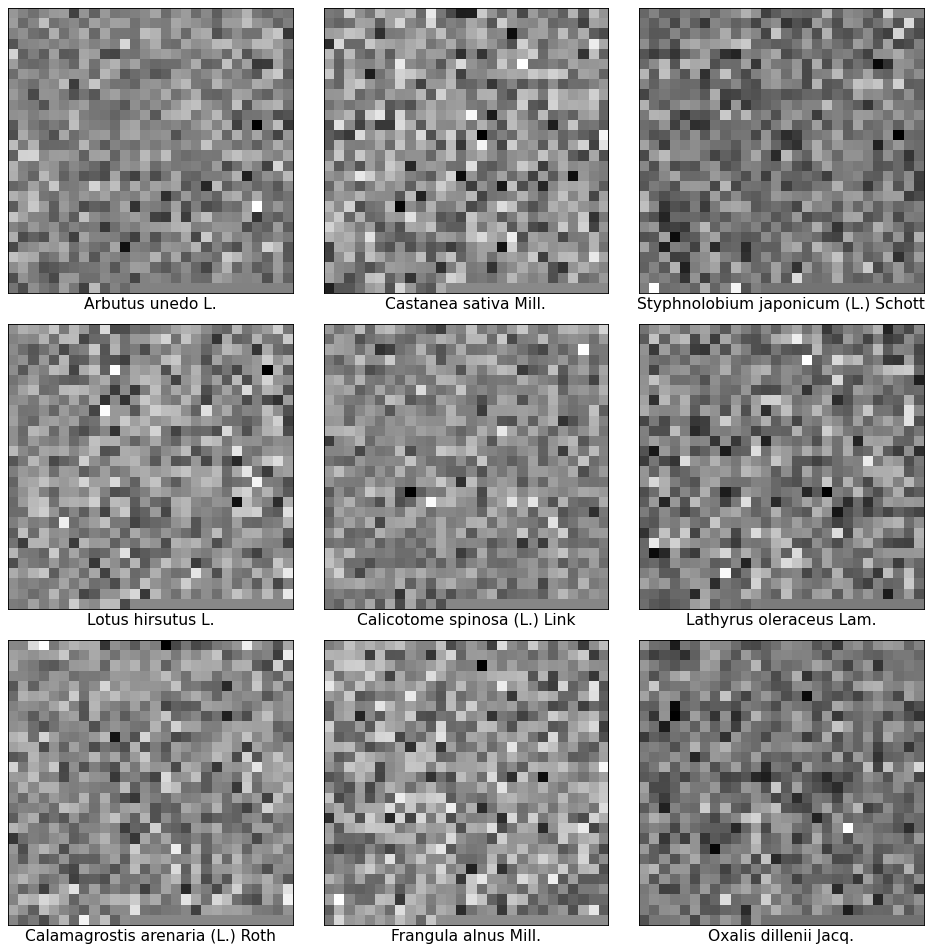

In [9]:
from plantclef.plotting import plot_images_from_embeddings

# Plot DINO image embeddings
plot_images_from_embeddings(
    joined_df, data_col="cls_embedding", image_col="species", grid_size=(3, 3)
)

### test embeddings

In [ ]:
# # Path and dataset names
# dino_emb_train = "test_v1/dino/data"

# # Define the GCS path to the embedding files
# dino_gcs_path = f"{gcs_path}/{dino_emb_train}"

# # Read the Parquet file into a DataFrame
# test_dino_df = spark.read.parquet(dino_gcs_path)

# # Show the data
# test_dino_df.show(n=5, truncate=50)

In [ ]:
# from plantclef.plotting import plot_images_from_embeddings

# # Plot test DINO image embeddings
# plot_images_from_embeddings(
#     test_dino_df, data_col="dino_embedding", image_col="image_name", grid_size=(3, 3)
# )